Importing necessary libraries

In [43]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import json
import os
from os import listdir
import cv2
from PIL import Image
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

Load Dataset and Preprocess Data

In [2]:
base_path = "C:/Users/umroot/Downloads/Dataset_ml/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [3]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
total_images

277524

In [4]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
1,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
2,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
3,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0
4,10253,C:/Users/umroot/Downloads/Dataset_ml/IDC_regul...,0


In [5]:
non_cancer_data = data.query("target == 0").head(2000)
print(non_cancer_data['target'].value_counts())
cancer_data = data.query("target == 1").head(2000)
print(cancer_data['target'].value_counts())
sliced_data = pd.concat([non_cancer_data,cancer_data])
print(sliced_data['target'].value_counts())

0    2000
Name: target, dtype: int64
1    2000
Name: target, dtype: int64
0    2000
1    2000
Name: target, dtype: int64


In [6]:
print(sliced_data['target'].value_counts())

0    2000
1    2000
Name: target, dtype: int64


In [7]:
sliced_data.target.unique()

array([0, 1], dtype=object)

In [8]:
sliced_data.shape

(4000, 3)

In [9]:
sliced_data.head()
sliced_data.loc[:, "target"] = data.target.astype(np.str)
sliced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 9253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  4000 non-null   object
 1   path        4000 non-null   object
 2   target      4000 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


In [10]:
unique_paths = sliced_data.path.unique()

In [11]:
sub_train_ids, test_ids = train_test_split(unique_paths,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

In [12]:
print(f"Now, we're taking {round(len(train_ids)/unique_paths.shape[0]*100, 1)}% for training, {round(len(valid_ids)/unique_paths.shape[0]*100,1)}% for validation, {round(len(test_ids)/unique_paths.shape[0]*100,1)}% for testing")


Now, we're taking 72.0% for training, 8.0% for validation, 20.0% for testing


In [13]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

2880, 320, 800


In [14]:
train_df = sliced_data.loc[sliced_data.path.isin(train_ids),:].copy()
test_df = sliced_data.loc[sliced_data.path.isin(test_ids),:].copy()
valid_df = sliced_data.loc[sliced_data.path.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (2880, 3)
test set shape: (800, 3)
validation set shape: (320, 3)


In [15]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
target_size = (224,224)
batch_size = 64

In [18]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 2880 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


Target distributions

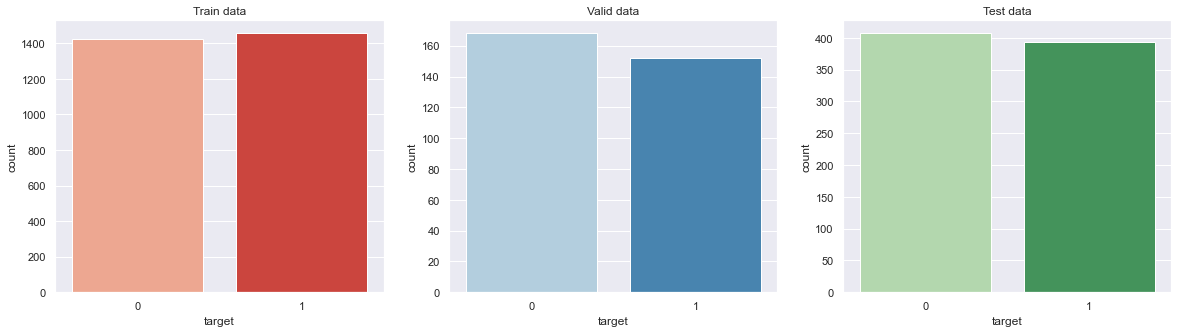

In [19]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

InceptionV3

Model Implementation

In [44]:
def InceptionV3(base_model,save_model_path):
    """Explanation:
    
    Arguments
    ---------
    base_model :
    tf.keras.applications.InceptionV3
    --------
    save_model_path : containing the path where to save the model.
    
    Returns
    ---------
    InceptionV3_model: keras.engine.functional.Functional
    -------------
    """ 
    """ Creating Model """

    base_model = base_model
    
    # Freezing Layers  
    """..Freezing the layers and making it non-training except the last three layers.."""
    for layer in base_model.layers[:-3]:
        
        layer.trainable=False 

    """ ...Building Inception Model...."""
    InceptionV3_model=Sequential() # Making it sequential 
    InceptionV3_model.add(base_model) # Adding the base_model to the sequencial model

    """Adding the Droupout and Flatten Layers"""
    InceptionV3_model.add(Dropout(0.5))
    InceptionV3_model.add(Flatten())

    """Adding Dense layer and sigmoid function"""
    InceptionV3_model.add(Dense(1,activation='sigmoid',name='output'))

    return InceptionV3_model

"""Call this function to create inceptionV3 model..."""        
InceptionV3_model = InceptionV3(base_model=tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet"),save_model_path="C:/Users/umroot/Desktop/Ml/test/")
InceptionV3_model.summary() # Summary of the created model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 output (Dense)              (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


Adding layer to network

In [27]:
InceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 output (Dense)              (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
InceptionV3_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.0001), metrics=['accuracy'])

In [31]:
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    "Breast_Cancer_InceptionV3_model.weights.best.h5", 
    save_best_only=True, 
    verbose = 1, 
    mode='max', 
    monitor='val_accuracy'
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    verbose=1
)

callbacks = [
    model_checkpoints,
    early_stopping
]

In [32]:
inception_history = InceptionV3_model.fit(train_batches, validation_data = valid_batches, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7184
Epoch 1: val_accuracy improved from -inf to 0.73750, saving model to Breast_Cancer_InceptionV3_model.weights.best.h5
45/45 [==============================] - 382s 8s/step - loss: 0.6738 - accuracy: 0.7184 - val_loss: 0.5474 - val_accuracy: 0.7375
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.8163
Epoch 2: val_accuracy improved from 0.73750 to 0.82812, saving model to Breast_Cancer_InceptionV3_model.weights.best.h5
45/45 [==============================] - 364s 8s/step - loss: 0.4654 - accuracy: 0.8163 - val_loss: 0.4339 - val_accuracy: 0.8281
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8278
Epoch 3: val_accuracy did not improve from 0.82812
45/45 [==============================] - 359s 8s/step - loss: 0.4454 - accuracy: 0.8278 - val_loss: 0.5345 - val_accuracy: 0.7875
Epoch 4/100
45/45 [==================

In [33]:
#Saving the models
InceptionV3_model.save("C:/Users/umroot/Desktop/Ml/inceptionv3_model.h5")

In [34]:
inception_model_loss, inception_model_accuracy = InceptionV3_model.evaluate(test_batches, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * inception_model_accuracy))
print("Restored model, loss: {:5.2f}%".format(100 * inception_model_loss))

13/13 - 72s - loss: 0.3769 - accuracy: 0.8788 - 72s/epoch - 6s/step
Restored model, accuracy: 87.88%
Restored model, loss: 37.69%


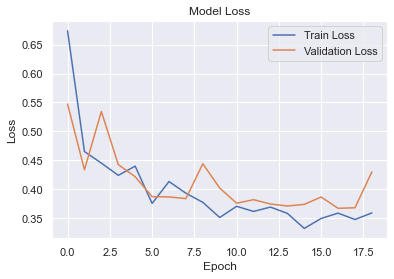

<Figure size 432x288 with 0 Axes>

In [35]:
#Loss
plt.plot(inception_history.history['loss'], label='Train Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.title("InceptionV3 Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

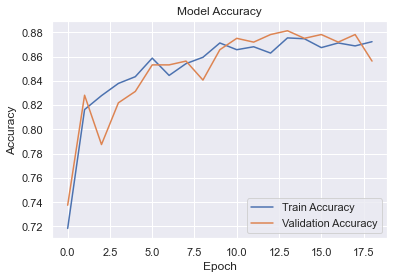

<Figure size 432x288 with 0 Axes>

In [36]:
#Accuracies
plt.plot(inception_history.history['accuracy'], label='Train Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("InceptionV3 Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

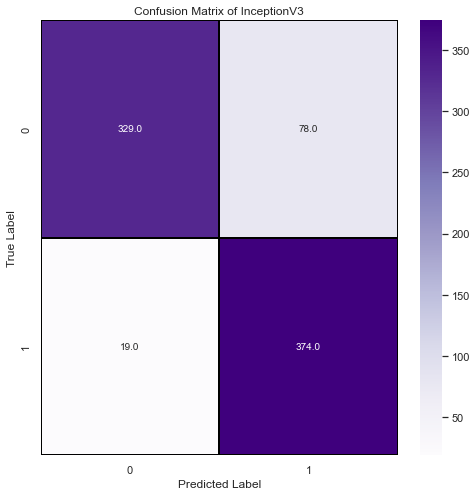

In [38]:

Y_pred_inception = InceptionV3_model.predict_generator(test_batches, test_df.shape[0] // batch_size+1)
y_pred_inception = np.where(Y_pred_inception > 0.5, 1, 0).flatten()
inception_cm = confusion_matrix(test_batches.classes, y_pred_inception)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(inception_cm, annot=True, linewidths=0.01,cmap="Purples",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of InceptionV3")
plt.show()

In [39]:
print(classification_report(test_batches.classes, y_pred_inception, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       407
           1       0.83      0.95      0.89       393

    accuracy                           0.88       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



In [41]:
from tensorflow.keras.models import load_model
model=load_model("inceptionv3_mode.h5")

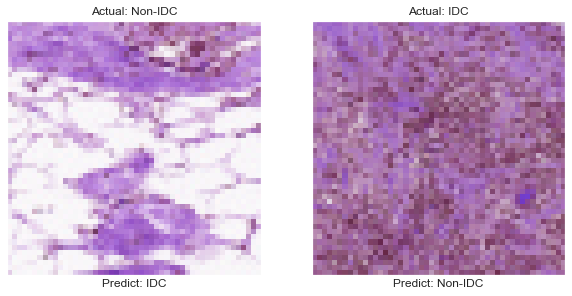

In [42]:
from PIL import Image
def prediction_for_inceptionv3(dataframe):
    plt.figure(figsize=(10,10))
    
    for i, v in enumerate([0, 799]):
        plt.subplot(1,2,i+1)
        image = cv2.imread(dataframe.loc[v, "path"])

        # create input data
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((224, 224))
        expand_input = np.expand_dims(resize_image, axis=0)
        input_data = np.array(expand_input)
        input_data = input_data/255

        # prediction
        prediction = model.predict(input_data)

        # plot the image
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.title("Actual: %s" % ("Non-IDC" if int(dataframe.loc[v, "target"]) == 0 else "IDC") )
        plt.xlabel("Predict: %s" % ("IDC" if prediction >= 0.5 else "Non-IDC"))
        
    plt.show()

prediction_for_inceptionv3(test_df)